Adaugarea bibliotecilor:



In [ ]:
!pip install pandas_datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 6.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Colectarea datelor:

In [ ]:
df = web.DataReader('MSFT', data_source='yahoo', start='2017-05-02', end='2022-05-02')

data = df.filter(['Close'])
set_date = data.values

Afisarea datelor:

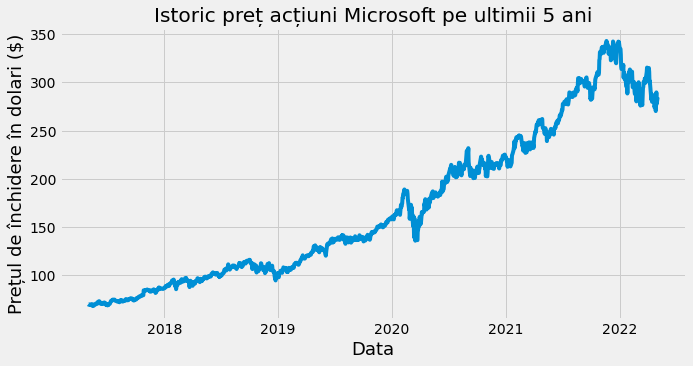

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Istoric preț acțiuni Microsoft pe ultimii 5 ani')
plt.plot(data)
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prețul de închidere în dolari ($)', fontsize=18)
plt.show()

Prelucrarea datelor:

In [ ]:
lungime_date_antrenare = math.ceil (len(set_date) * .9)

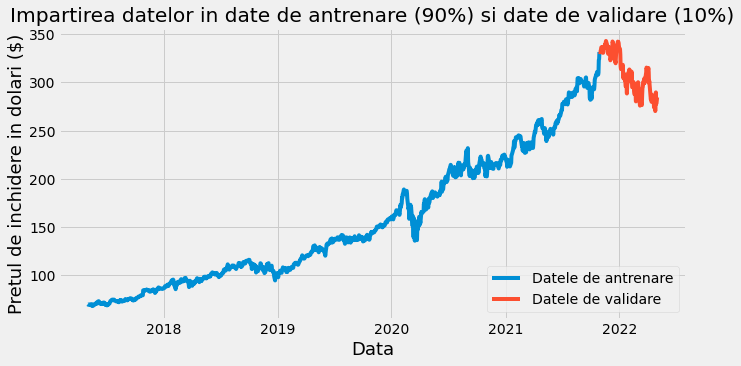

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Impartirea datelor in date de antrenare (90%) si date de validare (10%)')
plt.plot(df[0:lungime_date_antrenare]['Close'])
plt.plot(df[lungime_date_antrenare:]['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('Pretul de inchidere in dolari ($)', fontsize=18)
plt.legend(['Datele de antrenare', 'Datele de validare'], loc='lower right')
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
set_date_scalate = scaler.fit_transform(set_date)

In [ ]:
date_antrenare = set_date_scalate[0:lungime_date_antrenare , :]

x_antrenare = []
y_antrenare = []

for i in range(60, len(date_antrenare)):
  x_antrenare.append(date_antrenare[i-60:i, 0])
  y_antrenare.append(date_antrenare[i, 0])

In [ ]:
x_antrenare, y_antrenare = np.array(x_antrenare), np.array(y_antrenare)

x_antrenare = np.reshape(x_antrenare, (x_antrenare.shape[0], x_antrenare.shape[1], 1))

Crearea modelului:

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_antrenare.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

Antrenarea modelului:


In [ ]:
model.fit(x_antrenare, y_antrenare, batch_size=32, epochs=10)

Epoch 1/10
34/34 [==============================] - 7s 104ms/step - loss: 0.0388
Epoch 2/10
34/34 [==============================] - 4s 113ms/step - loss: 8.1620e-04
Epoch 3/10
34/34 [==============================] - 4s 114ms/step - loss: 4.9566e-04
Epoch 4/10
34/34 [==============================] - 4s 105ms/step - loss: 4.8764e-04
Epoch 5/10
34/34 [==============================] - 4s 123ms/step - loss: 4.7632e-04
Epoch 6/10
34/34 [==============================] - 4s 113ms/step - loss: 4.8104e-04
Epoch 7/10
34/34 [==============================] - 4s 110ms/step - loss: 4.8375e-04
Epoch 8/10
34/34 [==============================] - 4s 106ms/step - loss: 4.7545e-04
Epoch 9/10
34/34 [==============================] - 4s 108ms/step - loss: 4.5783e-04
Epoch 10/10
34/34 [==============================] - 2s 57ms/step - loss: 4.7470e-04


Verificarea pierderii:

In [ ]:
pierderea = model.history.history['loss']

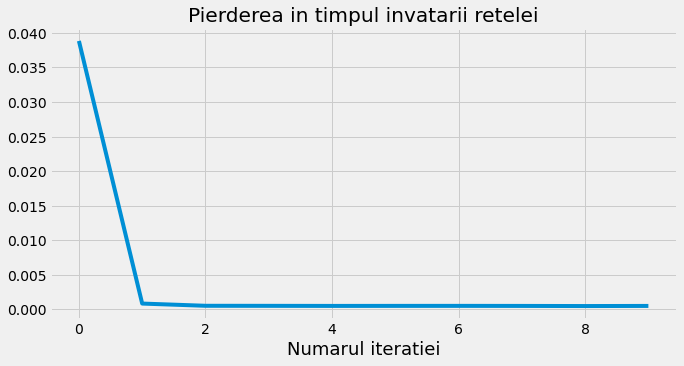

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Pierderea in timpul invatarii retelei')
plt.xlabel('Numarul iteratiei', fontsize=18)
plt.plot(pierderea)
plt.show()

Pregatirea datelor pentru predictii:

In [ ]:
date_testare = set_date_scalate[lungime_date_antrenare - 60: , :]

x_test = []
y_test = set_date[lungime_date_antrenare:, :]

for i in range(60, len(date_testare)):
  x_test.append(date_testare[i-60:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Efectuarea predictiilor:

In [ ]:
predictii = model.predict(x_test)
predictii = scaler.inverse_transform(predictii)

In [ ]:
antrenare = data[:lungime_date_antrenare]
validare = data[lungime_date_antrenare:]
validare['Predictii'] = predictii

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Afisarea predictiilor:

<function matplotlib.pyplot.show>

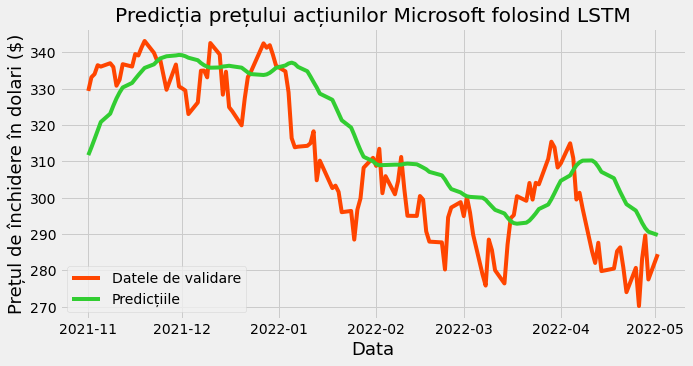

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Predicția prețului acțiunilor Microsoft folosind LSTM')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prețul de închidere în dolari ($)', fontsize=18)
plt.plot(validare['Close'], color = 'orangered')
plt.plot(validare['Predictii'], color='limegreen')
plt.legend(['Datele de validare', 'Predicțiile'], loc='lower left')
plt.show

<function matplotlib.pyplot.show>

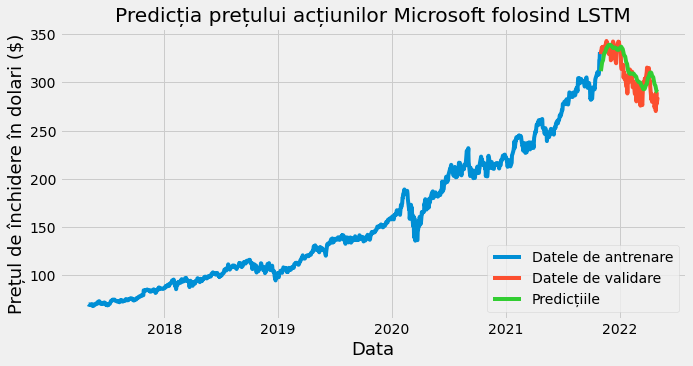

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Predicția prețului acțiunilor Microsoft folosind LSTM')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Prețul de închidere în dolari ($)', fontsize=18)
plt.plot(antrenare['Close'])
plt.plot(validare['Close'])
plt.plot(validare['Predictii'], color='limegreen')
plt.legend(['Datele de antrenare', 'Datele de validare', 'Predicțiile'], loc='lower right')
plt.show

Verificare R patrat:

In [ ]:
R_patrat = r2_score(validare['Close'], validare['Predictii'])
print('Coefecientul de determinare R patrat =', R_patrat) 

Coefecientul de determinare R patrat = 0.5652179228737794


Verificare MAPE:

In [ ]:
mape = np.mean(np.abs(predictii - y_test)/np.abs(y_test))
print('Eroare procentuala medie absoluta (MAPE) =', mape) 

Eroare procentuala medie absoluta (MAPE) = 0.03692939850830121


Predictia pentru urmatoarele 30 de zile:

In [ ]:
ultimele_60_zile = data[-60:].values
ultimele_60_zile_scalate = scaler.transform(ultimele_60_zile)

date_intrare = []
date_intrare.append(ultimele_60_zile_scalate)

date_intrare = np.array(date_intrare)
date_intrare = np.reshape(date_intrare, (date_intrare.shape[0], date_intrare.shape[1], 1))

for i in range (1,31):
  day_predicted = model.predict(date_intrare)
  date_intrare = np.delete(date_intrare, 0)
  date_intrare = np.append(date_intrare, day_predicted)
  date_intrare = np.reshape(date_intrare, (1, 60, 1))

predictie = scaler.inverse_transform(date_intrare[0])
predictie = predictie[30:]

In [ ]:
predictie_30_zile = pd.DataFrame(predictie,
                                 index=['2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12', '2022-05-13', '2022-05-16',
                                        '2022-05-17', '2022-05-18', '2022-05-19', '2022-05-20', '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-30',
                                        '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10', '2022-06-13'],
                                 columns = ['Predictii'])

In [ ]:
predictie_30_zile.index= pd.to_datetime(predictie_30_zile.index)

In [ ]:
ultimele_60_zile = data[len(data)-60:]

<function matplotlib.pyplot.show>

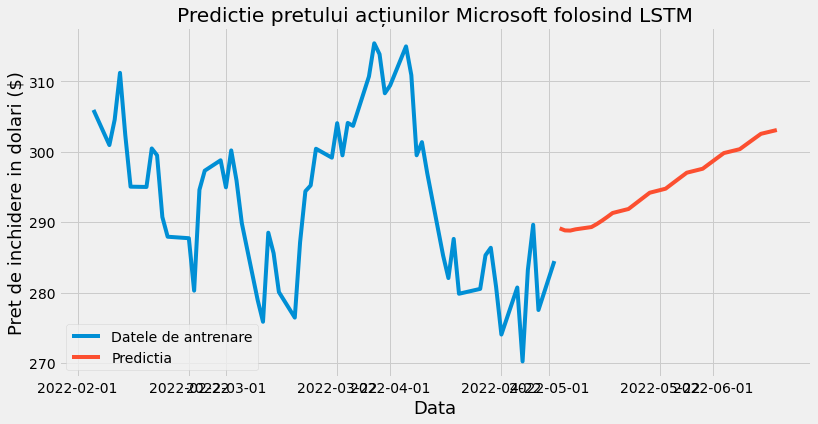

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Predictie pretului acțiunilor Microsoft folosind LSTM')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Pret de inchidere in dolari ($)', fontsize=18)
plt.plot(ultimele_60_zile['Close'])
plt.plot(predictie_30_zile['Predictii'])
plt.legend(['Datele de antrenare', 'Predictia'], loc='lower left')
plt.show